# **Bank Customer Churn Prediction**

#### This notebook predicts customer churn using machine learning.
#### It covers data preprocessing, EDA, model training, and evaluation to identify customers likely to leave the bank.

## **1. Imports & Settings**

In [1]:
# Import Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# ML utilities (Sklearn)
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

# Metrics & Utilities
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay, ConfusionMatrixDisplay
import joblib
import warnings
warnings.filterwarnings("ignore")

# Display Settings
sns.set_theme(style='whitegrid', palette='muted', font_scale=1.05)
pd.set_option('display.max_columns', 200)

## **2. Load the Data**

In [2]:
#Load Dataset
df = pd.read_csv("../Data/Bank Customer Churn Prediction.csv")
print("Shape:", df.shape)
df.head()

Shape: (10000, 12)


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## **3. Quick data overview**

In [3]:
# Clean column names
df.columns = df.columns.str.strip()
print("Columns:", df.columns.tolist())
print(df.dtypes)
print("\nMissing values per column:\n", df.isnull().sum())

# Basic stats
display(df.describe(include='all').T)

Columns: ['customer_id', 'credit_score', 'country', 'gender', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary', 'churn']
customer_id           int64
credit_score          int64
country              object
gender               object
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
churn                 int64
dtype: object

Missing values per column:
 customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customer_id,10000.0,NaN,NaN,NaN,15690940.5694,71936.186123,15565701.0,15628528.25,15690738.0,15753233.75,15815690.0
credit_score,10000.0,NaN,NaN,NaN,650.5288,96.653299,350.0,584.0,652.0,718.0,850.0
country,10000,3,France,5014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,10000,2,Male,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,10000.0,NaN,NaN,NaN,38.9218,10.487806,18.0,32.0,37.0,44.0,92.0
tenure,10000.0,NaN,NaN,NaN,5.0128,2.892174,0.0,3.0,5.0,7.0,10.0
balance,10000.0,NaN,NaN,NaN,76485.889288,62397.405202,0.0,0.0,97198.54,127644.24,250898.09
products_number,10000.0,NaN,NaN,NaN,1.5302,0.581654,1.0,1.0,1.0,2.0,4.0
credit_card,10000.0,NaN,NaN,NaN,0.7055,0.45584,0.0,0.0,1.0,1.0,1.0
active_member,10000.0,NaN,NaN,NaN,0.5151,0.499797,0.0,0.0,1.0,1.0,1.0


## **4. Data cleaning & target check**

In [4]:
# Ensure target exists and is numeric (churn)
if 'churn' not in df.columns:
    # try common alternatives
    alt = [c for c in df.columns if c.lower() in ('churn','exited','is_churn','churned','target')]
    if len(alt)>0:
        df.rename(columns={alt[0]: 'churn'}, inplace=True)
    else:
        raise KeyError("No 'churn' column found. Rename your target to 'churn' (0/1).")

# If churn is Yes/No -> map to 0/1
if df['churn'].dtype == object:
    df['churn'] = df['churn'].str.strip().map({'No':0,'Yes':1,'N':0,'Y':1}).astype(int)

print("Target distribution:\n", Counter(df['churn']))

# Drop ID column if exists
for idcol in ['customer_id','customerID','CustomerId','id']:
    if idcol in df.columns:
        df.drop(columns=[idcol], inplace=True)
        print("Dropped ID column:", idcol)
        break

Target distribution:
 Counter({0: 7963, 1: 2037})
Dropped ID column: customer_id


## **5. Feature engineering**

In [5]:
# Rename columns for consistency
rename_map = {
    'Balance': 'balance',
    'Tenure': 'tenure',
    'NumOfProducts': 'products_number',
    'Age': 'age'
}
df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns}, inplace=True)

# Example features (skip if missing)
if 'balance' in df.columns and 'tenure' in df.columns:
    df['balance_per_tenure'] = df['balance'] / (df['tenure'] + 1)

if 'products_number' in df.columns and 'tenure' in df.columns:
    df['products_per_tenure'] = df['products_number'] / (df['tenure'] + 1)

# Age bucket (example)
if 'age' in df.columns:
    df['age_bin'] = pd.cut(
        df['age'],
        bins=[0, 25, 35, 50, 65, 120],
        labels=['<25', '25-35', '35-50', '50-65', '65+']
    )

print("Feature engineering complete.")

Feature engineering complete.


## **6. Exploratory Data Analysis (EDA)**
### Distribution of numeric features, relationships with churn and categorical features

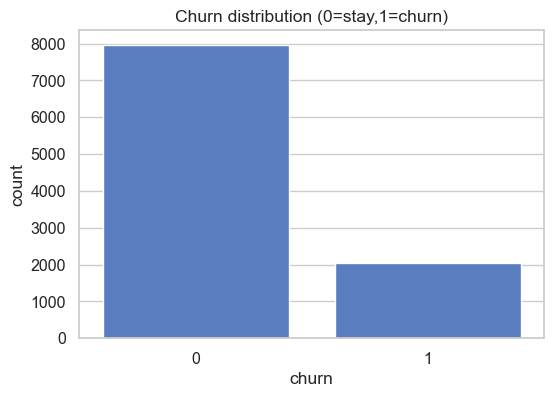

<Figure size 1200x600 with 0 Axes>

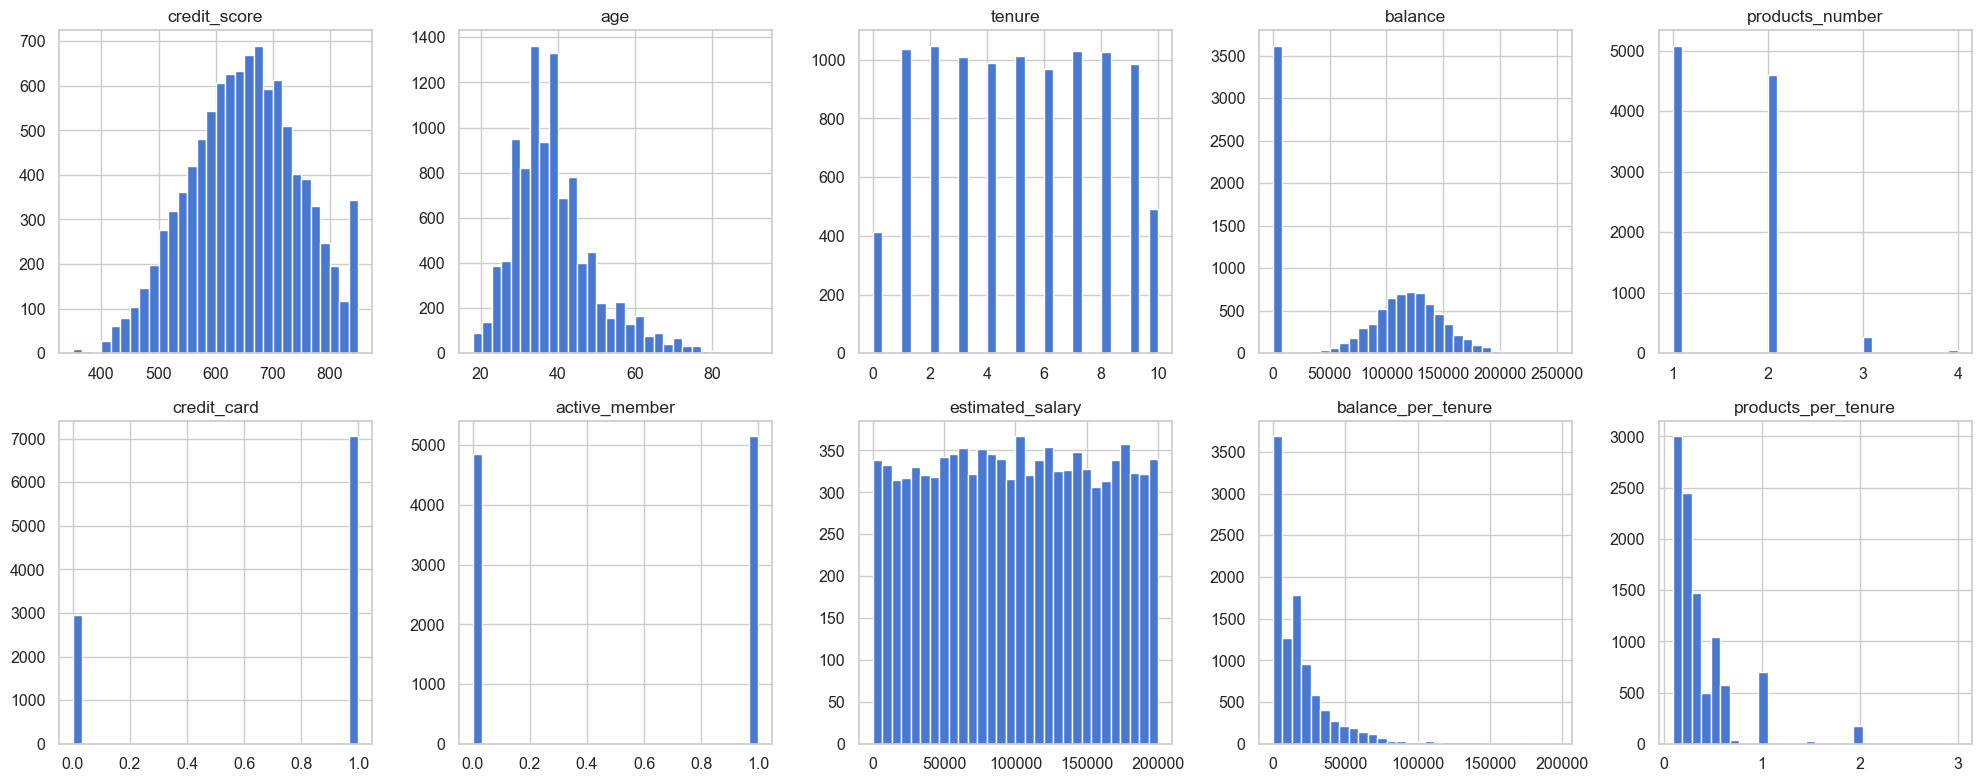

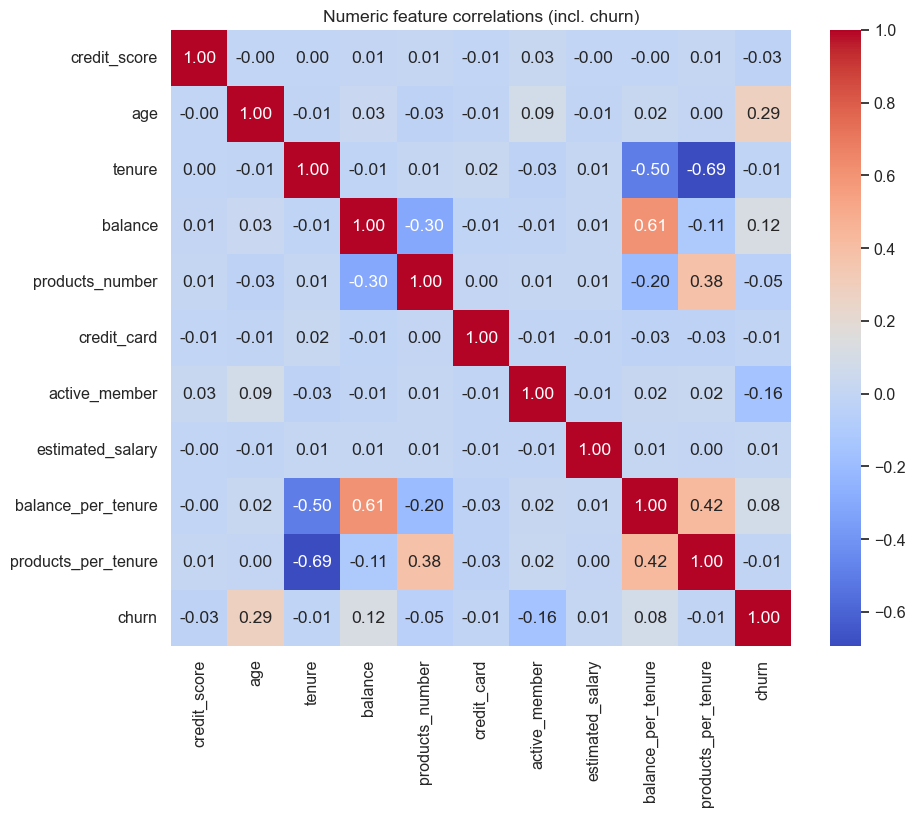

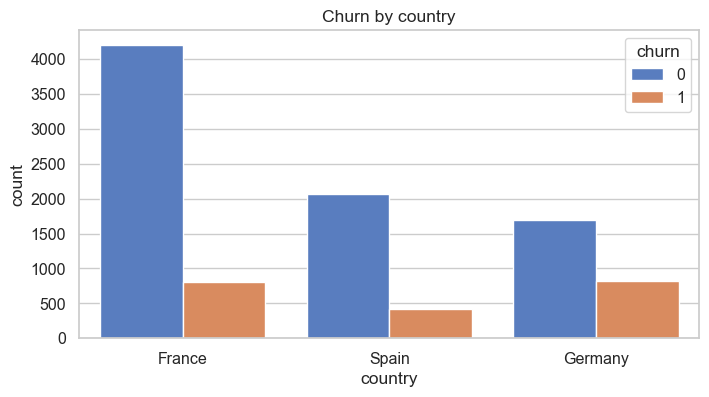

In [6]:
plt.figure(figsize=(6,4))
sns.countplot(x='churn', data=df)
plt.title('Churn distribution (0=stay,1=churn)')
plt.show()

# important numeric distributions
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove('churn')
plt.figure(figsize=(12,6))
df[num_cols].hist(bins=30, layout=(2,5), figsize=(20,8))
plt.tight_layout()
plt.show()

# Correlation heatmap (numeric)
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols + ['churn']].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Numeric feature correlations (incl. churn)")
plt.show()

# Example categorical churn relationship
if 'country' in df.columns:
    plt.figure(figsize=(8,4))
    sns.countplot(x='country', hue='churn', data=df)
    plt.title('Churn by country')
    plt.show()

 ## **7. Preprocessing pipeline**

In [7]:
# Identify column types
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
if 'churn' in numeric_features: numeric_features.remove('churn')
categorical_features = df.select_dtypes(include=['object','category']).columns.tolist()

print("Numeric:", numeric_features)
print("Categorical:", categorical_features)

# Simple imputers & scalers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
], remainder='drop')

# Test transform shapes
X = df.drop('churn', axis=1)
y = df['churn'].astype(int)

# Fit-preprocess
X_prep = preprocessor.fit_transform(X)
print("Preprocessed feature matrix shape:", X_prep.shape)

# Save preprocessor for later
os.makedirs("models", exist_ok=True)
joblib.dump(preprocessor, "models/preprocessor.joblib")

Numeric: ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary', 'balance_per_tenure', 'products_per_tenure']
Categorical: ['country', 'gender', 'age_bin']
Preprocessed feature matrix shape: (10000, 20)


['models/preprocessor.joblib']

## **8. Train/Test Split**

In [8]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_prep, y, test_size=0.2, random_state=42, stratify=y)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (8000, 20) Test shape: (2000, 20)


## **9. Models: define & train baseline** 

In [9]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "SVC": SVC(probability=True, random_state=42),
    "Naive Bayes": GaussianNB(),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

trained_models = {}
y_preds = {}
y_probs = {}

for name, model in models.items():
    print("Training:", name)
    model.fit(X_train, y_train)
    trained_models[name] = model
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    y_preds[name] = y_pred
    y_probs[name] = y_prob

Training: Logistic Regression
Training: Random Forest
Training: Gradient Boosting
Training: AdaBoost
Training: SVC
Training: Naive Bayes
Training: XGBoost


## **10. ANN (Keras) - using preprocessed numeric matrix**

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

input_dim = X_train.shape[1]
ann = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = ann.fit(X_train, y_train, validation_split=0.15, epochs=100, batch_size=64, callbacks=[es], verbose=0)

y_prob_ann = ann.predict(X_test).flatten()
y_pred_ann = (y_prob_ann > 0.5).astype(int)
trained_models['ANN'] = ann
y_preds['ANN'] = y_pred_ann
y_probs['ANN'] = y_prob_ann

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


## **11. Evaluation: metrics table**

In [11]:
def compute_metrics(y_true, y_pred, y_prob=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc = roc_auc_score(y_true, y_prob) if y_prob is not None else None
    return {"Accuracy":acc, "Precision":prec, "Recall":rec, "F1":f1, "ROC_AUC":roc}

metrics = {}
for name in y_preds:
    metrics[name] = compute_metrics(y_test, y_preds[name], y_probs.get(name, None))

metrics_df = pd.DataFrame(metrics).T
display(metrics_df.sort_values(by='ROC_AUC', ascending=False))

,Accuracy,Precision,Recall,F1,ROC_AUC
Gradient Boosting,0.8695,0.792000,0.486486,0.602740,0.869527
ANN,0.8620,0.788546,0.439803,0.564669,0.858601
Random Forest,0.8635,0.779167,0.459459,0.578053,0.850368
AdaBoost,0.8535,0.705036,0.481572,0.572263,0.848822
XGBoost,0.8555,0.706294,0.496314,0.582973,0.842639
SVC,0.8580,0.851429,0.366093,0.512027,0.819993
Logistic Regression,0.8180,0.631902,0.253071,0.361404,0.795196
Naive Bayes,0.7840,0.475149,0.587224,0.525275,0.781631


## **12. Plots: metrics, ROC, confusion matrices**

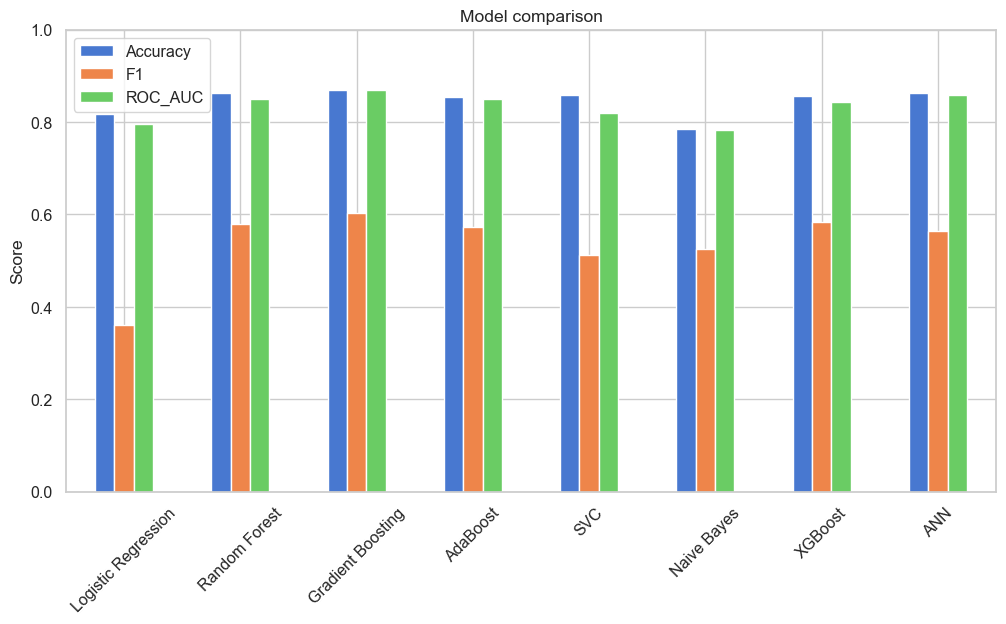

Best by ROC_AUC: Gradient Boosting


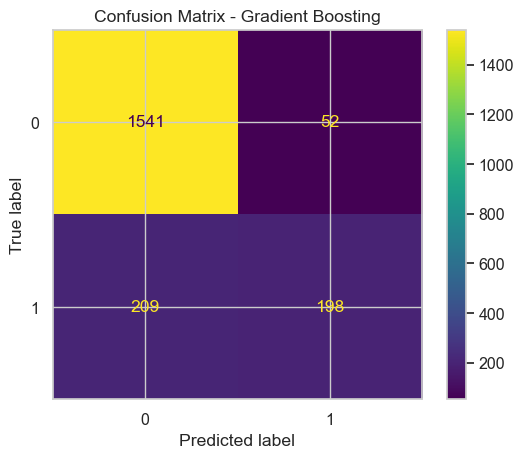

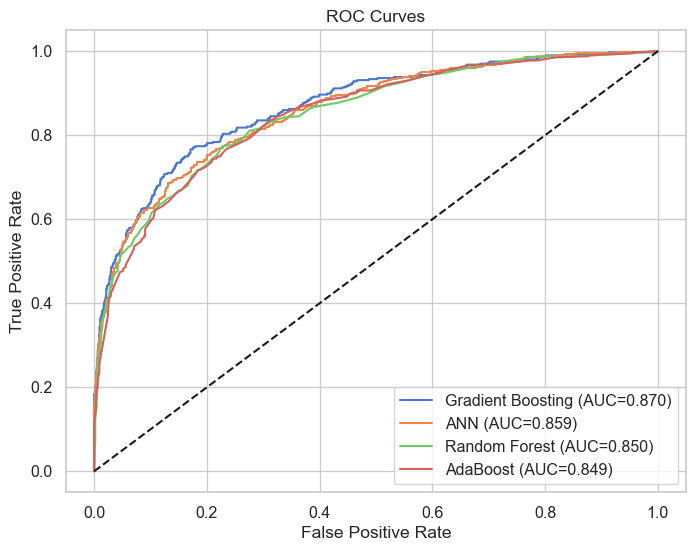

In [12]:
# Bar plot for metrics (Accuracy, F1, ROC_AUC)
metrics_plot = metrics_df[['Accuracy','F1','ROC_AUC']].fillna(0)
metrics_plot.plot(kind='bar', figsize=(12,6))
plt.title('Model comparison')
plt.ylabel('Score')
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.show()

# Confusion matrix for top model (by ROC_AUC)
best_model_name = metrics_df['ROC_AUC'].idxmax()
print("Best by ROC_AUC:", best_model_name)
ConfusionMatrixDisplay.from_predictions(y_test, y_preds[best_model_name])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.show()

# ROC curves for top 4 models
from sklearn.metrics import roc_curve
plt.figure(figsize=(8,6))
for name in list(metrics_df.sort_values(by='ROC_AUC', ascending=False).index)[:4]:
    fpr, tpr, _ = roc_curve(y_test, y_probs[name])
    plt.plot(fpr, tpr, label=f"{name} (AUC={metrics_df.loc[name,'ROC_AUC']:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

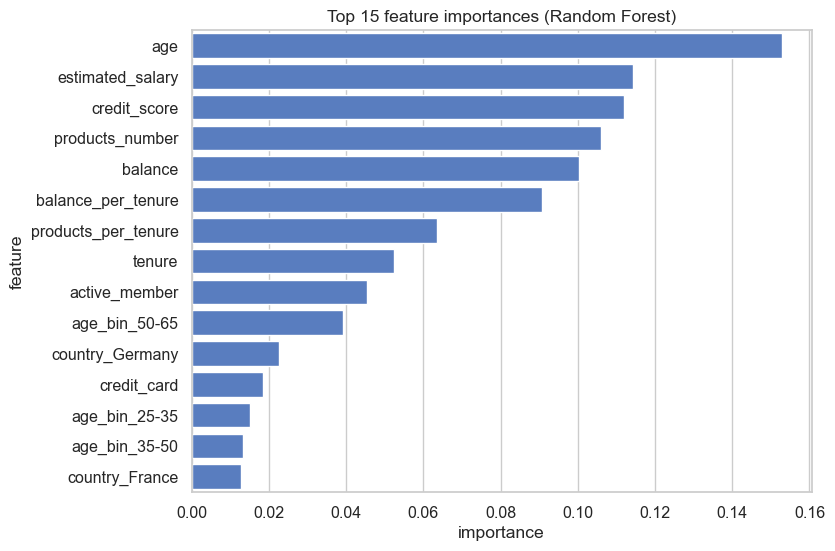

In [13]:
# Feature importance from RandomForest and XGBoost (unmask feature names)
# Recover feature names after onehot encoding
# Build a feature name list from preprocessor
ohe_cols = []
if 'cat' in preprocessor.named_transformers_:
    try:
        ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
        cat_names = preprocessor.transformers_[1][2]  # categorical features list
        # careful: get feature names
        ohe_cols = list(ohe.get_feature_names_out(cat_names))
    except Exception:
        ohe_cols = []
num_names = numeric_features
feature_names = num_names + ohe_cols

# Random Forest importance
if 'Random Forest' in trained_models:
    rf = trained_models['Random Forest']
    importances = rf.feature_importances_
    if len(importances) == len(feature_names):
        imp_df = pd.DataFrame({'feature':feature_names,'importance':importances}).sort_values(by='importance', ascending=False).head(15)
        plt.figure(figsize=(8,6))
        sns.barplot(x='importance', y='feature', data=imp_df)
        plt.title('Top 15 feature importances (Random Forest)')
        plt.show()

## **13. Hyperparameter tuning**

In [14]:
# Randomized search for RandomForest
rf = RandomForestClassifier(random_state=42)
param_dist = {
    'n_estimators': [100,200,400],
    'max_depth': [None, 8, 16, 24],
    'min_samples_split': [2,5,10]
}
rs = RandomizedSearchCV(rf, param_dist, n_iter=8, scoring='roc_auc', cv=3, n_jobs=-1, random_state=42)
rs.fit(X_train, y_train)
print("RF best params:", rs.best_params_)
best_rf = rs.best_estimator_
trained_models['Random Forest (tuned)'] = best_rf
y_preds['Random Forest (tuned)'] = best_rf.predict(X_test)
y_probs['Random Forest (tuned)'] = best_rf.predict_proba(X_test)[:,1]
print("Tuned RF AUC:", roc_auc_score(y_test, y_probs['Random Forest (tuned)']))

# XGBoost randomized search
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_param_dist = {
    'n_estimators': [100,200,400],
    'max_depth': [3,5,7],
    'learning_rate': [0.01,0.05,0.1]
}
rs_xgb = RandomizedSearchCV(xgb_clf, xgb_param_dist, n_iter=8, scoring='roc_auc', cv=3, n_jobs=-1, random_state=42)
rs_xgb.fit(X_train, y_train)
print("XGB best params:", rs_xgb.best_params_)
best_xgb = rs_xgb.best_estimator_
trained_models['XGBoost (tuned)'] = best_xgb
y_preds['XGBoost (tuned)'] = best_xgb.predict(X_test)
y_probs['XGBoost (tuned)'] = best_xgb.predict_proba(X_test)[:,1]
print("Tuned XGB AUC:", roc_auc_score(y_test, y_probs['XGBoost (tuned)']))

# Update metrics table
for name in ['Random Forest (tuned)','XGBoost (tuned)']:
    metrics[name] = compute_metrics(y_test, y_preds[name], y_probs[name])
metrics_df = pd.DataFrame(metrics).T
display(metrics_df.sort_values(by='ROC_AUC', ascending=False))

RF best params: {'n_estimators': 400, 'min_samples_split': 10, 'max_depth': 16}
Tuned RF AUC: 0.8558296354906524
XGB best params: {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.05}
Tuned XGB AUC: 0.8671059349025451


,Accuracy,Precision,Recall,F1,ROC_AUC
Gradient Boosting,0.8695,0.792000,0.486486,0.602740,0.869527
XGBoost (tuned),0.8690,0.786561,0.488943,0.603030,0.867106
ANN,0.8620,0.788546,0.439803,0.564669,0.858601
Random Forest (tuned),0.8640,0.811060,0.432432,0.564103,0.855830
Random Forest,0.8635,0.779167,0.459459,0.578053,0.850368
AdaBoost,0.8535,0.705036,0.481572,0.572263,0.848822
XGBoost,0.8555,0.706294,0.496314,0.582973,0.842639
SVC,0.8580,0.851429,0.366093,0.512027,0.819993
Logistic Regression,0.8180,0.631902,0.253071,0.361404,0.795196
Naive Bayes,0.7840,0.475149,0.587224,0.525275,0.781631


## **14. Save best model + preprocessor**

In [15]:
# Choose best by ROC_AUC
best_name = metrics_df['ROC_AUC'].idxmax()
print("Saving best model:", best_name)
os.makedirs("models", exist_ok=True)
# If ANN is best, save differently
if best_name == 'ANN':
    trained_models[best_name].save("models/best_model_ann.h5")
else:
    joblib.dump(trained_models[best_name], f"models/best_model_{best_name.replace(' ','_')}.joblib")
# Preprocessor already saved earlier as models/preprocessor.joblib

Saving best model: Gradient Boosting


## **15. Test new predictions**

In [16]:
# Load preprocessor
preprocessor = joblib.load("models/preprocessor.joblib")

# Load best model
if best_name == "ANN":
    from tensorflow.keras.models import load_model
    best_model = load_model("models/best_model_ann.h5")
else:
    best_model = joblib.load(f"models/best_model_{best_name.replace(' ','_')}.joblib")

# Example new data
new_data = pd.DataFrame({
    'credit_score':[650],
    'country':['France'],
    'gender':['Female'],
    'age':[40],
    'tenure':[5],
    'balance':[50000],
    'products_number':[2],
    'credit_card':[1],
    'active_member':[1],
    'estimated_salary':[60000]
})

# Feature engineering (same as training)
new_data['balance_per_tenure'] = new_data['balance'] / (new_data['tenure'] + 1)
new_data['products_per_tenure'] = new_data['products_number'] / (new_data['tenure'] + 1)
new_data['age_bin'] = pd.cut(new_data['age'], bins=[0,25,35,50,65,120], labels=['<25','25-35','35-50','50-65','65+'])

# Preprocess
X_new = preprocessor.transform(new_data)

# Predict churn probability
if best_name == "ANN":
    prob = best_model.predict(X_new)[0][0]
else:
    prob = best_model.predict_proba(X_new)[0][1]

print(f"Predicted churn probability: {prob:.2f}")


Predicted churn probability: 0.07


## **16. Summary**

In [17]:
# Save metrics summary
metrics_df.to_csv("models/model_performance_summary.csv", index=True)
print("Model performance summary saved to models/model_performance_summary.csv")

# Identify best model
best_model_name = metrics_df['ROC_AUC'].idxmax()
best_auc = metrics_df.loc[best_model_name, 'ROC_AUC']
best_acc = metrics_df.loc[best_model_name, 'Accuracy']

print("\n========== Final Summary ==========")
print(f"Best Model: {best_model_name}")
print(f"ROC-AUC Score: {best_auc:.4f}")
print(f"Accuracy: {best_acc:.4f}")
print("===================================")


Model performance summary saved to models/model_performance_summary.csv

========== Final Summary ==========
Best Model: Gradient Boosting
ROC-AUC Score: 0.8695
Accuracy: 0.8695
